In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
from scipy.stats import norm

In [2]:
def load_all_data(directory):
    left_data = []
    right_data = []
    subjects = []
    act_classes = []
    
    for filename in os.listdir(directory):
        if filename.endswith(".csv"):
            subject = filename.split("_")[0].strip()
            act_class = filename.split("_")[1].split(".")[0].strip()
            df = pd.read_csv(os.path.join(directory, filename), header=None)

            # Add the entire first and second column as an array to the respective lists
            left_data.append(df[0].values)
            right_data.append(df[1].values)
            subjects.append(subject)
            act_classes.append(act_class)

    # Combine into a DataFrame
    combined_data = pd.DataFrame({
        'left_data': left_data,
        'right_data': right_data,
        'subject': subjects,
        'act_class': act_classes
    })

    return combined_data

def normalize_all_data(df):
    # Concatenate all arrays in 'left_data' and 'right_data' to find the global min and max
    all_left_data = np.concatenate(df['left_data'].tolist())
    all_right_data = np.concatenate(df['right_data'].tolist())

    left_min, left_max = all_left_data.min(), all_left_data.max()
    right_min, right_max = all_right_data.min(), all_right_data.max()

    print(f"left_min: {left_min}, left_max: {left_max}")
    print(f"right_min: {right_min}, right_max: {right_max}")

    # Define normalization functions based on the global min and max
    def normalize(array, min_val, max_val):
        if max_val - min_val == 0:
            return array  # Avoid division by zero
        return (array - min_val) / (max_val - min_val)

    # Apply normalization to each array in 'left_data' and 'right_data'
    df['left_data'] = df['left_data'].apply(normalize, args=(left_min, left_max))
    df['right_data'] = df['right_data'].apply(normalize, args=(right_min, right_max))

    return df

In [3]:
all_data = load_all_data("data/DesktopActivity/ALL")
all_data_normalized = normalize_all_data(all_data)

left_min: -0.12492, left_max: 1.0873
right_min: -0.19863, right_max: 1.4762


In [4]:
def calculate_std_deviation(df):
    # Concatenate all arrays in 'left_data' and 'right_data'
    all_left_data = np.concatenate(df['left_data'].tolist())
    all_right_data = np.concatenate(df['right_data'].tolist())

    # Calculate the standard deviation for the concatenated data
    std_dev_left = np.std(all_left_data)
    std_dev_right = np.std(all_right_data)

    # Print the standard deviations
    print(f"Standard Deviation for left_data: {std_dev_left}")
    print(f"Standard Deviation for right_data: {std_dev_right}")

    return std_dev_left, std_dev_right

# Calculate and print the standard deviations
std_left, std_right = calculate_std_deviation(all_data_normalized)

Standard Deviation for left_data: 0.09782551290226099
Standard Deviation for right_data: 0.12052316716926113


In [5]:
def apply_windowing(df, window_size, overlap):
    step_size = int(window_size * (1 - overlap))
    print(f"The step size of each sample is {step_size}, this is determined via the overlap")

    left_data_segments = []
    right_data_segments = []
    labels = []
    subjects = []

    for index, row in df.iterrows():
        left_data_array = row['left_data']
        right_data_array = row['right_data']
        label = row['act_class']  # or any other label you wish to use
        subject = row['subject']

        # Apply windowing for left_data
        for i in range(0, len(left_data_array) - window_size + 1, step_size):
            window = left_data_array[i:i + window_size]
            left_data_segments.append(window)
            labels.append(label)
            subjects.append(subject)

        # Apply windowing for right_data
        for i in range(0, len(right_data_array) - window_size + 1, step_size):
            window = right_data_array[i:i + window_size]
            right_data_segments.append(window)
            # Labels and subjects are the same for both left and right data

    # Combine into a DataFrame
    windowed_data = pd.DataFrame({
        'left_data': left_data_segments,
        'right_data': right_data_segments,
        'label': labels,
        'subject': subjects
    })

    return windowed_data
windowed_data_normalized = apply_windowing(all_data_normalized, 300, 0.8)

The step size of each sample is 59, this is determined via the overlap


In [6]:
print(windowed_data_normalized.head())
print(windowed_data_normalized.info())

                                           left_data  \
0  [0.417828446981571, 0.4195855537773672, 0.4193...   
1  [0.567636237646632, 0.559857121644586, 0.47971...   
2  [0.5321888766065566, 0.5156489746085695, 0.512...   
3  [0.49554536305291125, 0.49622180792265436, 0.4...   
4  [0.5517480325353484, 0.5503868934681825, 0.549...   

                                          right_data label subject  
0  [0.4559507532107736, 0.45598657774221857, 0.45...  PLAY     P04  
1  [0.4485828412435889, 0.44666622881128226, 0.41...  PLAY     P04  
2  [0.3223133094105073, 0.3336935688995301, 0.331...  PLAY     P04  
3  [0.36400709325722613, 0.3664909274374115, 0.36...  PLAY     P04  
4  [0.3300633497131052, 0.33221282159980414, 0.33...  PLAY     P04  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7104 entries, 0 to 7103
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   left_data   7104 non-null   object
 1   right_data  7104 n

In [7]:
# def extend_data_with_gaussian_distribution(windowed_data, std_left, std_right, gaussian_length):
#     # Reduced standard deviations
#     std_left /= 10  # Example: Reducing by half
#     std_right /= 10  # Example: Reducing by half
# 
#     extended_left_data = []
#     extended_right_data = []
# 
#     for index, row in windowed_data.iterrows():
#         # Extend left_data
#         left_data_segment = row['left_data']
#         extended_left_segment = []
#         for datum in left_data_segment:
#             x = np.linspace(datum - 3*std_left, datum + 3*std_left, gaussian_length)
#             y = (1 / (std_left * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - datum) / std_left) ** 2)
#             extended_left_segment.append(y)
#         extended_left_data.append(np.array(extended_left_segment).T)
# 
#         # Extend right_data
#         right_data_segment = row['right_data']
#         extended_right_segment = []
#         for datum in right_data_segment:
#             x = np.linspace(datum - 3*std_right, datum + 3*std_right, gaussian_length)
#             y = (1 / (std_right * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - datum) / std_right) ** 2)
#             extended_right_segment.append(y)
#         extended_right_data.append(np.array(extended_right_segment).T)
# 
#     # Create a new DataFrame with extended data
#     extended_data = pd.DataFrame({
#         'left_data': extended_left_data,
#         'right_data': extended_right_data,
#         'label': windowed_data['label'],
#         'subject': windowed_data['subject']
#     })
# 
#     return extended_data


def extend_data_with_gaussian_distribution(windowed_data, std_left, std_right, gaussian_length):
    extended_left_data = []
    extended_right_data = []

    for index, row in windowed_data.iterrows():
        # Extend left_data
        left_data_segment = row['left_data']
        extended_left_segment = []
        for datum in left_data_segment:
            x = np.linspace(0, 1, gaussian_length)
            y = norm.pdf(x, loc=datum, scale=std_left)
            extended_left_segment.append(y)
        extended_left_data.append(np.array(extended_left_segment).T)

        # Extend right_data
        right_data_segment = row['right_data']
        extended_right_segment = []
        for datum in right_data_segment:
            x = np.linspace(0, 1, gaussian_length)
            y = norm.pdf(x, loc=datum, scale=std_right)
            extended_right_segment.append(y)
        extended_right_data.append(np.array(extended_right_segment).T)

    # Create a new DataFrame with extended data
    extended_data = pd.DataFrame({
        'left_data': extended_left_data,
        'right_data': extended_right_data,
        'label': windowed_data['label'],
        'subject': windowed_data['subject']
    })

    return extended_data


extended_data = extend_data_with_gaussian_distribution(windowed_data_normalized, std_left, std_right, 200)

In [8]:
print(extended_data.head())
print(extended_data.info())

                                           left_data  \
0  [[0.0004457404093699498, 0.0004127567268367025...   
1  [[1.9917316826144612e-07, 3.149558771452569e-0...   
2  [[1.5270474564571093e-06, 3.7766790416856523e-...   
3  [[1.0924054307895499e-05, 1.0547781705567946e-...   
4  [[5.044139507237039e-07, 5.455403952464011e-07...   

                                          right_data label subject  
0  [[0.002582663042761655, 0.0025797603703425153,...  PLAY     P04  
1  [[0.003248597969355731, 0.0034462454676304675,...  PLAY     P04  
2  [[0.09265006463485982, 0.07165446501229361, 0....  PLAY     P04  
3  [[0.03459988084804142, 0.032505027015069674, 0...  PLAY     P04  
4  [[0.07785100206823009, 0.07412822372131388, 0....  PLAY     P04  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7104 entries, 0 to 7103
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   left_data   7104 non-null   object
 1   right_data  7104 n

In [9]:
print(extended_data['right_data'][0].shape)

(200, 300)


In [10]:
def save_figures_to_folder(extended_data, folder_path, num_to_plot=10):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    plotted = {}  # Dictionary to keep track of plotted label-subject combinations

    for index, row in extended_data.head(num_to_plot).iterrows():
        left_data = np.array(row['left_data'])
        right_data = np.array(row['right_data'])
        label = row['label']
        subject = row['subject']

        # Invert-normalize each column of left_data and right_data
        def invert_normalize(data):
            normalized_data = np.zeros_like(data)
            for i in range(data.shape[1]):  # Iterate over columns
                column_min = data[:, i].min()
                column_max = data[:, i].max()
                if column_max != column_min:
                    normalized_data[:, i] = 1 - ((data[:, i] - column_min) / (column_max - column_min))
                else:
                    normalized_data[:, i] = 1 - data[:, i]
            return normalized_data

        normalized_left_data = invert_normalize(left_data)
        normalized_right_data = invert_normalize(right_data)

        # Create a unique identifier for each label-subject combination
        label_subject = f"{label}_{subject}"
        if label_subject not in plotted:
            plotted[label_subject] = 1
        else:
            plotted[label_subject] += 1

        fig, axs = plt.subplots(1, 2, figsize=(12, 6))

        # Plot normalized left data
        axs[0].imshow(normalized_left_data, cmap='gray', vmin=0, vmax=1)
        axs[0].set_title('Left Data')
        axs[0].axis('off')

        # Plot normalized right data
        axs[1].imshow(normalized_right_data, cmap='gray', vmin=0, vmax=1)
        axs[1].set_title('Right Data')
        axs[1].axis('off')

        # Save the figure
        plt.savefig(os.path.join(folder_path, f"{label_subject}_{plotted[label_subject]}.png"))
        plt.close()

# Example usage
save_figures_to_folder(extended_data, 'generated_prob_figures', num_to_plot=10)

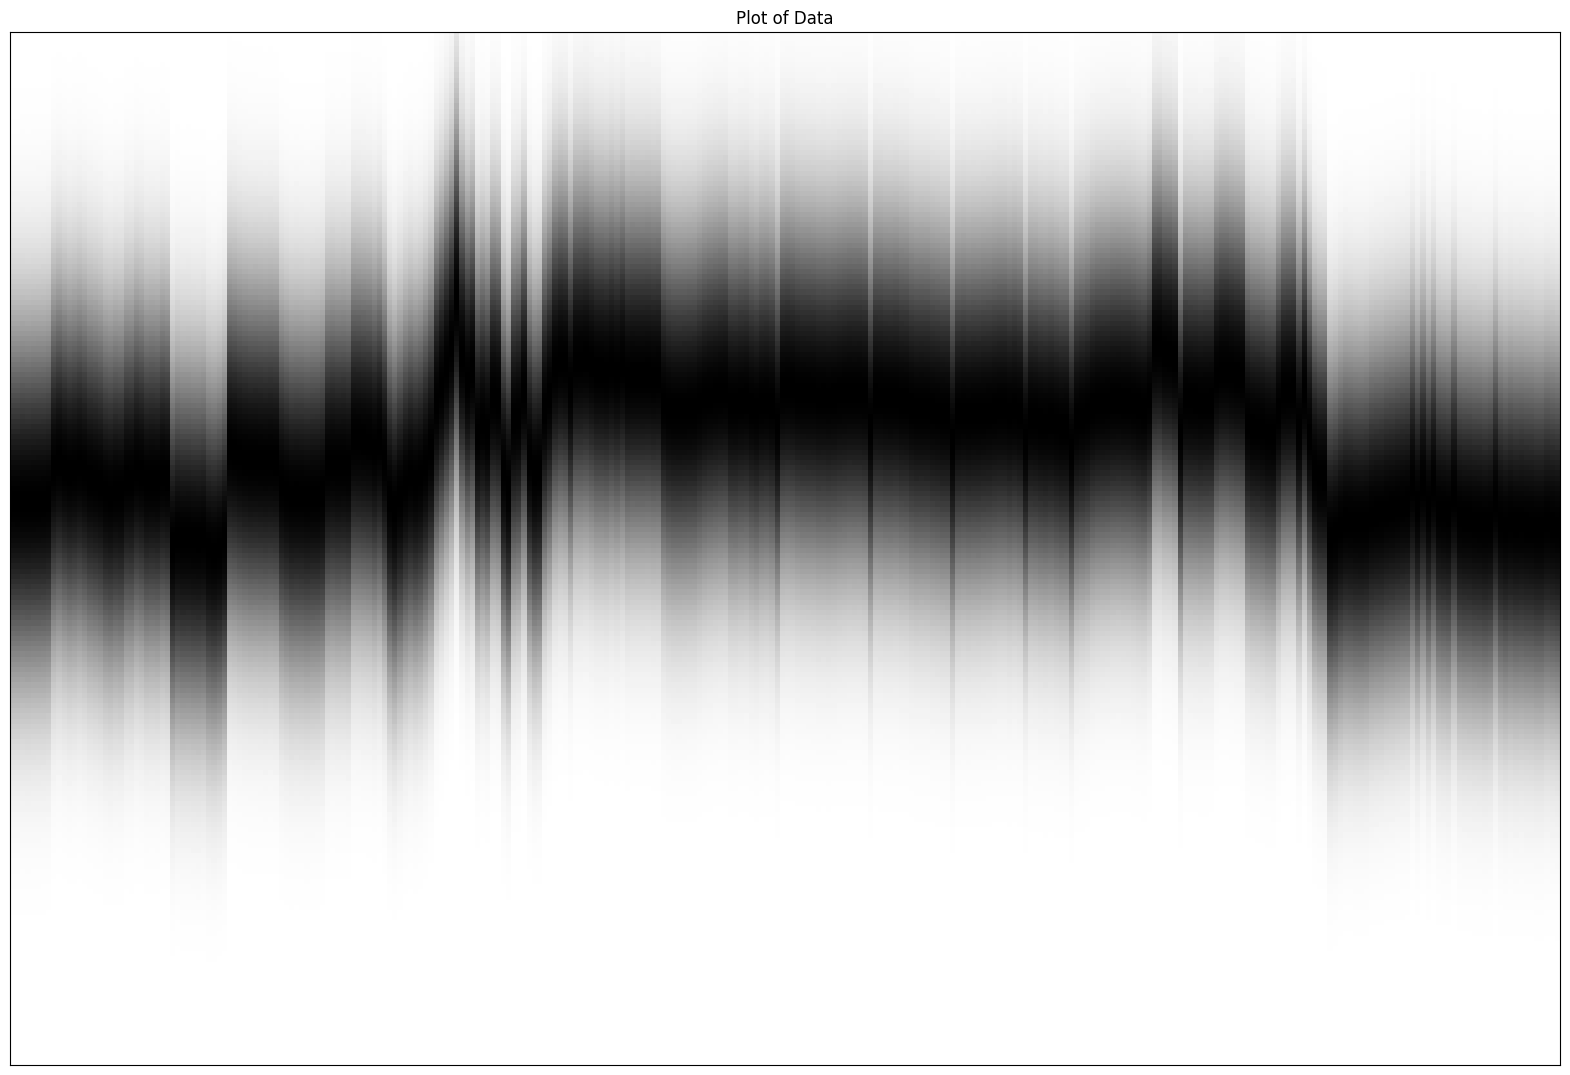

In [11]:
# Assuming plot_data is already defined as extended_data['right_data'][0]
plot_data = extended_data['right_data'][0]

# Invert-normalize each column by its maximum and minimum values
inverted_normalized_plot_data = np.zeros_like(plot_data)
for i in range(plot_data.shape[1]):  # Iterate over columns
    column_min = plot_data[:, i].min()
    column_max = plot_data[:, i].max()
    # Avoid division by zero
    if column_max != column_min:
        inverted_normalized_plot_data[:, i] = 1 - ((plot_data[:, i] - column_min) / (column_max - column_min))
    else:
        inverted_normalized_plot_data[:, i] = 1 - plot_data[:, i]

# Set up the figure
plt.figure(figsize=(20, 30))  # Adjust the size as needed

# Display the data as an image with grayscale
# 'cmap' sets the color map to grayscale
plt.imshow(inverted_normalized_plot_data, cmap='gray', vmin=0, vmax=1)

# Remove axis ticks
plt.xticks([])
plt.yticks([])

# Optionally, you can add a title
plt.title('Plot of Data')

# Show the plot
plt.show()